In [58]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [59]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

In [60]:
device='cpu'

## Define target density

In [244]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [271]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [246]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

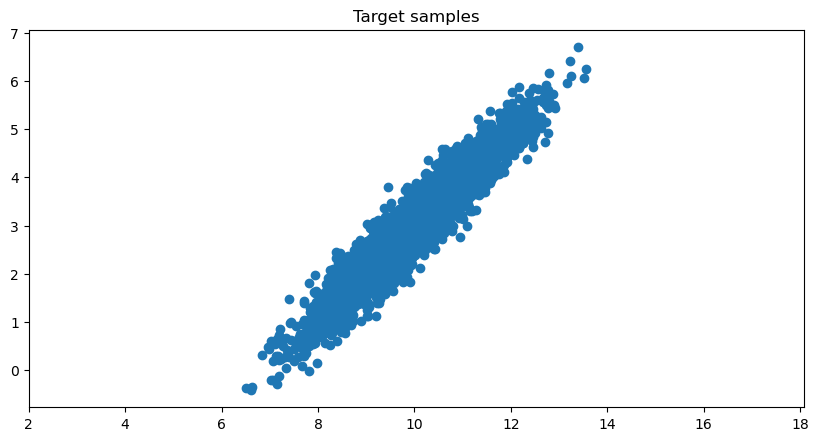

In [247]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [248]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [249]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [250]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▊                                                                          | 231/10000 [00:00<00:08, 1168.74it/s]

Current value of KL at batch number 0 is 277.7289123535156


 12%|█████████▏                                                                 | 1226/10000 [00:01<00:07, 1237.53it/s]

Current value of KL at batch number 1000 is 18.290681838989258


 22%|████████████████▌                                                          | 2212/10000 [00:01<00:06, 1213.05it/s]

Current value of KL at batch number 2000 is 9.80843448638916


 32%|████████████████████████                                                   | 3203/10000 [00:02<00:05, 1181.11it/s]

Current value of KL at batch number 3000 is 3.798171281814575


 42%|███████████████████████████████▎                                           | 4180/10000 [00:03<00:04, 1171.75it/s]

Current value of KL at batch number 4000 is 1.5624668598175049


 52%|██████████████████████████████████████▉                                    | 5199/10000 [00:04<00:03, 1241.48it/s]

Current value of KL at batch number 5000 is 1.1814453601837158


 62%|██████████████████████████████████████████████▎                            | 6178/10000 [00:05<00:03, 1175.83it/s]

Current value of KL at batch number 6000 is 1.2159212827682495


 72%|█████████████████████████████████████████████████████▊                     | 7181/10000 [00:06<00:02, 1193.95it/s]

Current value of KL at batch number 7000 is 1.1428207159042358


 81%|█████████████████████████████████████████████████████████████              | 8137/10000 [00:06<00:01, 1147.70it/s]

Current value of KL at batch number 8000 is 1.149654507637024


 92%|████████████████████████████████████████████████████████████████████▉      | 9187/10000 [00:07<00:00, 1076.70it/s]

Current value of KL at batch number 9000 is 1.0785000324249268


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1162.92it/s]


### Plot both: samples from variational family and target

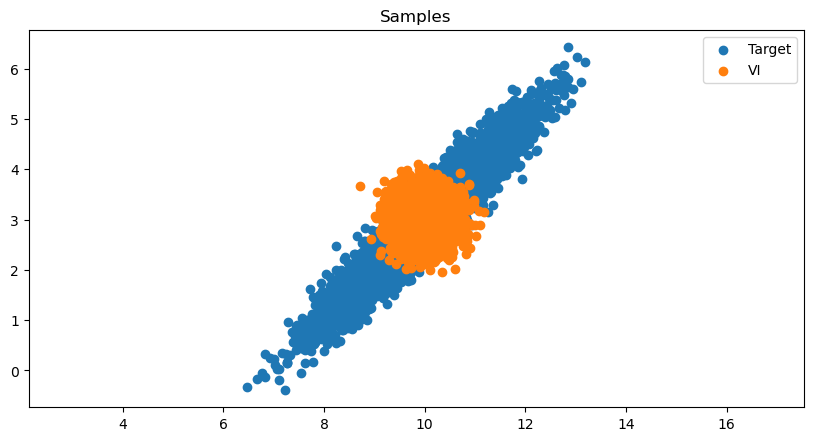

In [251]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

In [252]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [280]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)#torch.rand(2,2)), 1)

In [281]:
target_gmm = GMM(mix, comp)

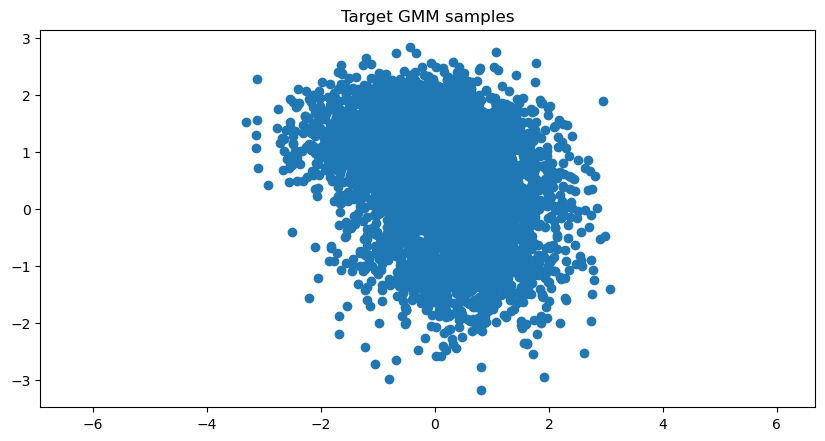

In [282]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

In [283]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [284]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  0%|▏                                                                             | 31/10000 [00:00<00:33, 299.18it/s]

Current value of KL at batch number 0 is 0.30139851570129395


 10%|███████▊                                                                    | 1025/10000 [00:03<00:44, 200.01it/s]

Current value of KL at batch number 1000 is 0.12587761878967285


 20%|███████████████▍                                                            | 2039/10000 [00:06<00:24, 318.49it/s]

Current value of KL at batch number 2000 is 0.1555018424987793


 30%|███████████████████████▏                                                    | 3048/10000 [00:09<00:19, 360.59it/s]

Current value of KL at batch number 3000 is 0.13840579986572266


 41%|██████████████████████████████▊                                             | 4054/10000 [00:12<00:18, 318.96it/s]

Current value of KL at batch number 4000 is 0.16144418716430664


 50%|██████████████████████████████████████▎                                     | 5040/10000 [00:16<00:16, 306.98it/s]

Current value of KL at batch number 5000 is 0.1336367130279541


 60%|█████████████████████████████████████████████▉                              | 6038/10000 [00:19<00:13, 290.42it/s]

Current value of KL at batch number 6000 is 0.15421462059020996


 71%|█████████████████████████████████████████████████████▋                      | 7059/10000 [00:22<00:09, 299.88it/s]

Current value of KL at batch number 7000 is 0.1566164493560791


 81%|█████████████████████████████████████████████████████████████▏              | 8059/10000 [00:25<00:05, 368.76it/s]

Current value of KL at batch number 8000 is 0.13265657424926758


 91%|████████████████████████████████████████████████████████████████████▊       | 9051/10000 [00:29<00:03, 302.22it/s]

Current value of KL at batch number 9000 is 0.17631268501281738


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.11it/s]


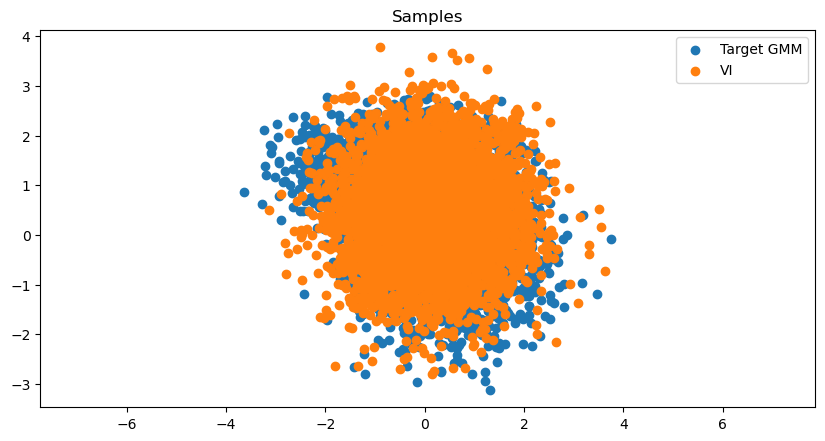

In [285]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();